In [2]:
import geopandas as gpd
import pandas as pd
import copy
import os
import warnings
import random
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pickle

from shapely.geometry import LineString, Point
import h3
from srai.h3 import h3_to_geoseries
import contextily as ctx


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DUMMIES = pd.get_dummies([1, 2, 3, 4, 5, 6])
DUMMIES

,1,2,3,4,5,6
0,True,False,False,False,False,False
1,False,True,False,False,False,False
2,False,False,True,False,False,False
3,False,False,False,True,False,False
4,False,False,False,False,True,False
5,False,False,False,False,False,True


In [4]:
def get_hex_neigh(traj):
    h3_dist = []
    h3_cells = []
    points = traj.coords
    for idx in range(len(points) - 1):
        a, b = points[idx], points[idx + 1]
        start_hex = h3.latlng_to_cell(a[1], a[0], H3_RESOLUTION)
        end_hex = h3.latlng_to_cell(b[1], b[0], H3_RESOLUTION)
        if start_hex == end_hex:
            continue
        for h3_cell in h3.grid_path_cells(start_hex, end_hex):
            if not h3_cells or h3_dist[-1] != h3_cell:
                # print(h3.grid_disk(h3_cell, 1))
                h3_dist.append(h3_cell)
                h3_cells.append(h3.grid_disk(h3_cell, 1))
    return h3_cells

In [5]:
def get_y(traj):
    if not traj:
        return None
    y = []
    for i in range(len(traj) - 1):
        target = traj[i + 1][0]
        prop = np.array(traj[i])
        res = prop == target
        # print(res)
        idx = np.where(res)[0]-1
        try:
            dummy = DUMMIES.loc[idx].values[0]
        except:
            print(traj)
        y.append(dummy)
    return y

In [6]:
def embed(traj):
    emb = []
    for t in traj:
        temp = []
        for h in t:
            try:
                temp.append(embeddings.loc[h].values)
            except:
                return None
        emb.append(temp)
    return emb

In [7]:
H3_RESOLUTION = 8
seq_length = 15
data_path = 'input_data'
path = f'data_res{H3_RESOLUTION}_seq{seq_length}'
path = os.path.join(data_path, path)

# Train Test load

In [8]:
# X_train, y_train = torch.load(os.path.join(path, 'train.pt'))
# X_test, y_test = torch.load(os.path.join(path, 'test.pt'))

with open(os.path.join(path, 'train_small.pkl'), 'rb') as f:
    X_train, y_train = pickle.load(f)

with open(os.path.join(path, 'test_small.pkl'), 'rb') as f:
    X_test, y_test = pickle.load(f)

In [9]:
print("Train size")
print(X_train.shape, y_train.shape)
print("Test size")
print(X_test.shape, y_test.shape)

Train size
(200000, 15) (200000,)
Test size
(40000, 15) (40000,)


In [10]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.unsqueeze(0)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out


In [12]:
def load_model(model_path, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.5):
    model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_rate)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model


model_path = f'model_{H3_RESOLUTION}_{seq_length}.pth'
input_size = len(X_train.iloc[0][0])
hidden_size = 128
output_size = 6
num_layers = 2
dropout_rate = 0.6

model = load_model(model_path, input_size, hidden_size, output_size, num_layers, dropout_rate)
print(model)

LSTMModel(
  (lstm): LSTM(70, 128, num_layers=2, batch_first=True, dropout=0.6)
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)


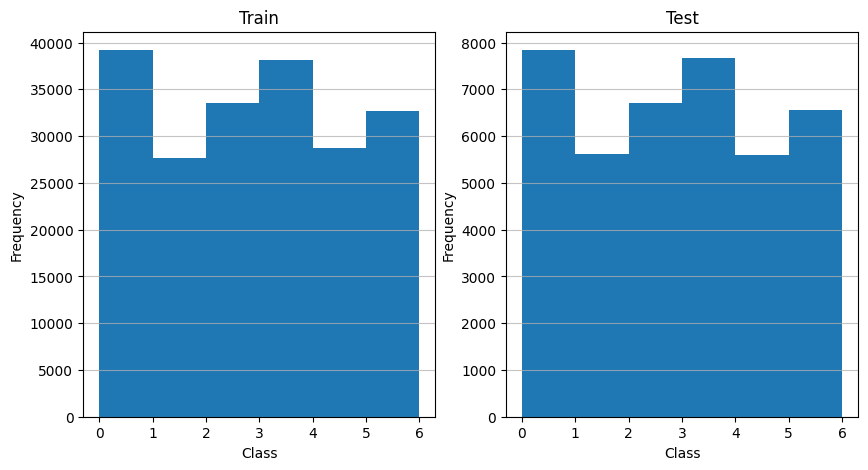

In [12]:
dist = []
for i in y_train:
    id_max = np.argmax(i)
    dist.append(id_max)

test_dist = []
for i in y_test:
    id_max = np.argmax(i)
    test_dist.append(id_max)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(dist, bins=range(7))
ax[0].set_title('Train')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')
ax[0].grid(axis='y', alpha=0.75)

ax[1].hist(test_dist, bins=range(7))
ax[1].set_title('Test')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')
ax[1].grid(axis='y', alpha=0.75)
plt.show()

In [13]:
embeddings = pd.read_parquet(os.path.join('output_data', f'embeddings_{H3_RESOLUTION}.parquet'))
embeddings.shape

(32149, 10)

In [14]:
gdf = gpd.read_parquet(os.path.join('output_data', 'geolife_pekin_clean_small.parquet'))
gdf.head()

,geometry,time,altitude,trajectory_id,contains_outlier
0,"LINESTRING (442545.429 4426752.285, 442548.618...","[2000-01-01T23:12:19.000000, 2000-01-01T23:13:...","[128.937004593176, 221.128615485564, 217.19159...",20000101231219,False
1,"LINESTRING (442820.014 4425112.043, 442825.777...","[2007-04-12T09:31:32.000000, 2007-04-12T09:39:...","[823.490813648294, 823.490813648294, 741.46981...",20070412093132,False
2,"LINESTRING (442812.545 4425254.546, 442822.785...","[2007-04-12T10:18:53.000000, 2007-04-12T10:20:...","[351.049868766404, 114.829396325459, 114.82939...",20070412101853,False
3,"LINESTRING (442794.835 4425360.126, 442801.896...","[2007-04-12T10:21:16.000000, 2007-04-12T10:21:...","[173.884514435696, 173.884514435696, 173.88451...",20070412102116,False
4,"LINESTRING (442822.785 4425291.468, 442828.589...","[2007-04-12T10:23:25.000000, 2007-04-12T10:24:...","[114.829396325459, 114.829396325459, 118.11023...",20070412102325,False


In [15]:
gdf = gdf.to_crs(4326)

In [16]:
# gdf_agg = gdf.groupby('trajectory_id').agg(
#     {'geometry': LineString, 'date_str': list, 'speed': list, 'altitude': list,
#      'trajectory_id': 'first'})
# gdf_agg.shape

In [17]:
gdf_agg = gdf.copy()

In [32]:
ls = gdf_agg['geometry'].iloc[993] # 515
h3_cells = []
points = ls.coords[:-55]
for idx in range(len(points) - 1):
    a, b = points[idx], points[idx + 1]
    start_hex = h3.latlng_to_cell(a[1], a[0], H3_RESOLUTION)
    end_hex = h3.latlng_to_cell(b[1], b[0], H3_RESOLUTION)
    if start_hex == end_hex:
        continue
    for h3_cell in h3.grid_path_cells(start_hex, end_hex):
        if not h3_cells or h3_cells[-1] != h3_cell:
            h3_cells.append(h3_cell)
m = h3_to_geoseries(h3_cells[:-2]).reset_index().explore("index", tiles="CartoDB positron", opacity=0.4)
gpd.GeoSeries([LineString(points)]).explore(m=m)

In [87]:
s_len = 1
points = ls.coords[1000:1400]
neigh = h3.grid_disk(h3_cells[s_len - 25], 1)
m = h3_to_geoseries(neigh).reset_index().explore("index", tiles="CartoDB positron", opacity=0.4)
gpd.GeoSeries([LineString(points)]).explore(m=m)

In [20]:
t = gdf_agg['geometry'].iloc[3] # 515
cells = get_hex_neigh(t)
y = get_y(cells)
em = embed(cells)
y

[array([False, False,  True, False, False, False]),
 array([ True, False, False, False, False, False]),
 array([False, False, False,  True, False, False]),
 array([False, False, False,  True, False, False]),
 array([False, False, False, False,  True, False]),
 array([False, False, False,  True, False, False]),
 array([False, False, False, False,  True, False]),
 array([False, False, False,  True, False, False]),
 array([False, False, False,  True, False, False]),
 array([False, False, False,  True, False, False]),
 array([False, False, False, False,  True, False]),
 array([False, False, False,  True, False, False]),
 array([False, False, False, False,  True, False]),
 array([False, False, False,  True, False, False]),
 array([False, False,  True, False, False, False]),
 array([False, False,  True, False, False, False]),
 array([False, False,  True, False, False, False]),
 array([False, False, False, False,  True, False]),
 array([False, False, False,  True, False, False]),
 array([Fals

In [21]:
test = np.array(em)
flatten = test.reshape(test.shape[0], -1)
flatten = torch.tensor(flatten, dtype=torch.float32)
flatten = flatten[:s_len]
flatten.shape

torch.Size([1, 70])

In [22]:
pred = torch.argmax(model(flatten))
pred, np.argmax(y[s_len - 1])

(tensor(0), 2)

In [23]:
neigh = h3_cells[:s_len] + [h3.grid_disk(h3_cells[s_len - 1])[pred.item()]]
m = h3_to_geoseries(neigh)
m = m.reset_index().explore("index", tiles="CartoDB positron", opacity=0.4)
gpd.GeoSeries([ls]).explore(m=m)
m

# SEKWENCJA

In [121]:
ls = gdf_agg['geometry'].iloc[99] # 838, 6123
h3_cells = []
points = ls.coords

for idx in range(len(points) - 1):
    a, b = points[idx], points[idx + 1]
    start_hex = h3.latlng_to_cell(a[1], a[0], H3_RESOLUTION)
    end_hex = h3.latlng_to_cell(b[1], b[0], H3_RESOLUTION)
    if start_hex == end_hex:
        continue
    for h3_cell in h3.grid_path_cells(start_hex, end_hex):
        if not h3_cells or h3_cells[-1] != h3_cell:
            h3_cells.append(h3_cell)
m = h3_to_geoseries(h3_cells).reset_index().explore("index", tiles="CartoDB positron", opacity=0.4)
print(len(h3_cells))
# convert points to Linestring
from shapely.geometry import LineString
points = LineString(points)
gpd.GeoSeries([points]).explore(m=m)

7


In [89]:
# m = h3_to_geoseries(h3_cells).reset_index()#.explore("index", tiles="CartoDB positron", opacity=0.4)
# g_series = gpd.GeoSeries([ls])#.explore(m=m)
# fig, ax = plt.subplots(figsize=(20, 10))
# m.plot(ax=ax, alpha=0.4, color='blue')  # Dodanie trajektorii na mapę
# g_series.plot(ax=ax, color='red')       # Dodanie wielokątów na mapę
# # add basemape 
# ctx.add_basemap(ax, crs='epsg:4326', source=ctx.providers.CartoDB.Positron)

# plt.show()

In [106]:
t = gdf_agg['geometry'].iloc[13] # 515, 816 8-good
cells = get_hex_neigh(t)
preds = []
pred_hex = [h3_cells[0]]
for i in range(len(cells)):
    y = get_y(cells)
    em = embed(cells)
    test = np.array(em)
    flatten = test.reshape(test.shape[0], -1)
    flatten = torch.tensor(flatten, dtype=torch.float32)
    flatten = flatten[:i + 1]
    pred = torch.argmax(model(flatten)) + 1
    preds.append(pred.item())
    pred_hex.append(h3.grid_disk(h3_cells[i])[pred.item()])
trues = [np.argmax(i) for i in y]

In [107]:
m = h3_to_geoseries(pred_hex).reset_index().explore("index", tiles="CartoDB positron", opacity=0.4)
gpd.GeoSeries([points]).explore(m=m)